Problem:


A robot is trying to navigate it's way out. In order to understand where it might have reached, it is using the GPS sensor. Unfortunatey the Sensor lost the signal. Dues to this, in order to locate itself it is using the wheel acceleration and we have GPS to get the x, y, we use them to estimate the vx and vy of the robot w.r.t the previous position. In order to address this, we use Kalman filter with Constant acceleration model as we are assuming the robot is moving with constant acceleration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
dt = 0.1

### Implementation of Kalman Filter with Constant Acceleratio Model (CA)       

In constant acceleration, we assume that the acceleration of the ego vehicle is moving with a constant acceleration. Thus, with time we don't update the acceleration value in the prediction step but we update the position and velocity of the ego vehicle.

The generic kalman filter looks like this.

<img src="kF.png" >

#### Prediction Step (Motion Model)

In the Kalman Filter (KF), the state matrix contains the parameters <u>**[Dx, Dy, Vx, Vy]**</u> of the robot.

The state matrix of ego robot:  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


Text(0.5, 1.0, 'Initial Position')

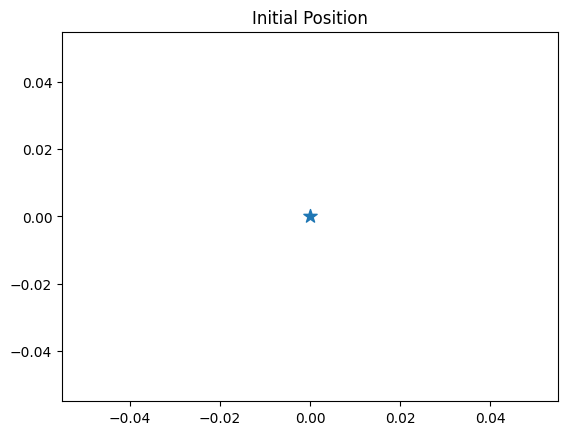

In [2]:
x = np.matrix([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).T
print("The state matrix of ego robot: ", x)
plt.scatter(float(x[0]), float(x[1]), s=100, marker='*')
plt.title("Initial Position")

The state transition matrix <u>**F**</u> defines how the state paramters are related based on the Motion model.

The motion model in KFCA is a simple linear motion model.
From this we construct the Dynamic matrix F.

$$
A = \frac{Velocity}{time} \\
\\
V = \frac{Distance}{time} \\
\\
Dx_{t+1} = Dx_t + Vx_t \times \Delta t + \frac{1}{2} ax_t \Delta t^2 \\
\\
Dy_{t+1} = Dy_t + Vy_t \times \Delta t + \frac{1}{2} ay_t \Delta t^2 \\
\\
Vx_{t+1} = Vx_t + Ax_t \times \Delta t\\
\\
Vy_{t+1} = Vy_t  + Ay_t \times \Delta t\\
\\
Ax_{t+1} = Ax_t\\
\\
Ay_{t+1} = Ay_t
$$


From this we write down the state transition matrix (F).

$$
F = 
\begin{bmatrix}
1 & 0 & \Delta t & 0 &0.5\times\Delta t^2 &0 \\
0 & 1 & 0 & \Delta t &0 &0.5\times\Delta t^2\\
0 & 0 & 1 & 0 &\Delta t &0\\
0 & 0 & 0 & 1 &0 &\Delta t\\
0 & 0 & 0 & 0 &1 &0\\
0 & 0 & 0 & 0 &0 &1\\
\end{bmatrix}
$$


In [3]:
F = np.matrix([[1.0, 0.0, dt, 0.0, 0.5*dt*dt, 0.0], [0.0, 1.0, 0.0, dt, 0.0, 0.5*dt*dt], [0.0, 0.0, 1.0, 0.0, dt, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, dt], [0.0, 0.0, 0.0, 0.0, 1.0, 0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
print("State Transition matrix: ", F)

State Transition matrix:  [[1.    0.    0.1   0.    0.005 0.   ]
 [0.    1.    0.    0.1   0.    0.005]
 [0.    0.    1.    0.    0.1   0.   ]
 [0.    0.    0.    1.    0.    0.1  ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    1.   ]]


The state matrix (X) contains the means of the parameters being tracked, while the uncertainty or standard deviation of these parameters are defined in the Error Covariance matrix (P).

$$
P = 
\begin{bmatrix}
\sigma_{dx_1}^2 & 0 & 0 & 0 &0 &0 \\
0 & \sigma_{dy_1}^2 & 0 & 0 &0 &0\\
0 & 0 & \sigma_{vx}^2 & 0 &0 &0\\
0 & 0 & 0 & \sigma_{vy}^2 &0 &0\\
0 & 0 & 0 & 0 &\sigma_{ax}^2 &0\\
0 & 0 & 0 & 0 &0 &\sigma_{ay}^2\\

\end{bmatrix}
$$

This is a general assumption of the KF where other than diagonal elements the matrix is filled with zeros. Yet, this is not followed in practice as if we know the prior understanding of relations between them, we can fill in thoses values. 

**Covariance:**

Covariance is a statistical measure, which define how change in one parameter shows up in the other. i.e., if X is a random variable which defines the students scores, and Y is a random variable which defines the no. of hours he studied, the covariance between the (X, Y) caluculatio based on the observed data would be positive.

Covariance can be calculated by,

$$
\text{cov}(X,Y) = E[(X - \mu_X)(Y - \mu_Y)]
$$





In order to find the covariance, we must calculate the mean of the X and Y variables, normalize the data and then find the expectation.

### Initial Uncertainity

In [4]:
P = np.diag([100.0, 100.0, 10.0, 10.0, 1.0, 1.0])
print("Initial Error Covariance: ", P)

Initial Error Covariance:  [[100.   0.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.]
 [  0.   0.  10.   0.   0.   0.]
 [  0.   0.   0.  10.   0.   0.]
 [  0.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   1.]]


The Position of the vehicle can be influenced by the force of air, which disturb the car. We assume sigma a as athe magnitude of the std of acceleration

The process covariance is modelled by

$$
Q = 
\begin{bmatrix}
\sigma_{dx}^2 & 0 & \sigma_{dx}\sigma_{vx} & 0 &\sigma_{dx}\sigma_{ax} & 0\\
0 & \sigma_{dy}^2 & 0 & \sigma_{dy}\sigma_{vy} &0 &\sigma_{dy}\sigma_{ay}\\
\sigma_{vx}\sigma_{dx} & 0 & \sigma_{vx}^2 & 0 &\sigma_{vx}\sigma_{ax} & 0\\
0 & \sigma_{vy}\sigma_{dy} & 0 & \sigma_{vy}^2 &0 & \sigma_{vy}\sigma_{ay}\\
\sigma_{ax}\sigma_{dx} & 0 & \sigma_{vx}\sigma_{ax} & 0 &\sigma_{ax}^2 & 0\\
0 & \sigma_{ay}\sigma_{dy} & 0 & \sigma_{vy}\sigma_{ay} &0 & \sigma_{ay}^2\\
\end{bmatrix} . \sigma_{a}
$$


In order find the Q matrix, we need to first find the dependency of distance on jerk.



$$
\sigma_{dx} = \frac{1}{6} \Delta t^3
$$

Similarly we find for velocity,
We know
$$
 \sigma_{vx} = \frac{1}{2} \Delta t^3
$$

Similarly we find for Acceleration,
We know
$$
 \sigma_{ax} =\Delta t
$$

If we substitute them above, we get the below matrix.


### A better explanation: To easily calcualte Q, one can ask the question: How the noise effects my state vector? For example, how the jerk change the position over one timestep dt. With $\sigma_{j}$ as the magnitude of the standard deviation of the jerk, which distrubs the car. We do not assume cross correlation, which means if a jerk will act in x direction of the movement, it will not push in y direction at the same time.


In [5]:
sj = 0.1

Q = np.matrix([[(dt**6)/36, 0, (dt**5)/12, 0, (dt**4)/6, 0],
               [0, (dt**6)/36, 0, (dt**5)/12, 0, (dt**4)/6],
               [(dt**5)/12, 0, (dt**4)/4, 0, (dt**3)/2, 0],
               [0, (dt**5)/12, 0, (dt**4)/4, 0, (dt**3)/2],
               [(dt**4)/6, 0, (dt**3)/2, 0, (dt**2),0],
               [0, (dt**4)/6, 0, (dt**3)/2, 0, (dt**2)]]) *sj**2

print("Measurement covariance Matrix Q: ", Q)

Measurement covariance Matrix Q:  [[2.77777778e-10 0.00000000e+00 8.33333333e-09 0.00000000e+00
  1.66666667e-07 0.00000000e+00]
 [0.00000000e+00 2.77777778e-10 0.00000000e+00 8.33333333e-09
  0.00000000e+00 1.66666667e-07]
 [8.33333333e-09 0.00000000e+00 2.50000000e-07 0.00000000e+00
  5.00000000e-06 0.00000000e+00]
 [0.00000000e+00 8.33333333e-09 0.00000000e+00 2.50000000e-07
  0.00000000e+00 5.00000000e-06]
 [1.66666667e-07 0.00000000e+00 5.00000000e-06 0.00000000e+00
  1.00000000e-04 0.00000000e+00]
 [0.00000000e+00 1.66666667e-07 0.00000000e+00 5.00000000e-06
  0.00000000e+00 1.00000000e-04]]


#### Measurement Model

Assuming, we are estimating the acceleration of the car, i.e, we have a acceleration measurement sensor. And we are the predicting the X, Y, Vx and Vy components of the car. 

Then the H Measurement Matrix will look like:


$$
H = 
\begin{bmatrix}
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

As we are only seeing the acceleration measurement, this is how the H matrix looks, if in case we also get the vlocity then the H matrix will be 4 X 6 matrix

In [6]:
H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
print(H, H.shape)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]] (4, 6)


As we are estimating the Dx and Dy, and we only get reading of Vx and Vy from sensor, we define the H matrix as above where Dx and Dy Columns are related to Vx and Vy rows.

In [7]:
ra = 10.0**2   # Noise of Acceleration Measurement
rp = 100.0**2  # Noise of Position Measurement
R = np.matrix([[rp, 0.0, 0.0, 0.0],
               [0.0, rp, 0.0, 0.0],
               [0.0, 0.0, ra, 0.0],
               [0.0, 0.0, 0.0, ra]])
print("Measurement Noise Covariance Matrix R: ", R)

Measurement Noise Covariance Matrix R:  [[10000.     0.     0.     0.]
 [    0. 10000.     0.     0.]
 [    0.     0.   100.     0.]
 [    0.     0.     0.   100.]]


### Positions Data

In [8]:
m = 500 # Measurements

# Acceleration values
sp = 1 # std of position
px = 0.0
py = 0.0

mpx = np.array(px+sp*np.random.randn(m))
mpy = np.array(py+sp*np.random.randn(m))


# Generate GPS Trigger
GPS = np.ndarray(m,dtype='bool')
GPS[0]=True

# Less new position updates
for i in range(1,m):
    if i%10==0:
        GPS[i]=True
    else:
        mpx[i]=mpx[i-1]
        mpy[i]=mpy[i-1]
        GPS[i]=False

print('Standard Deviation of position Measurements=%.2f' % np.std(mpx))
print('You assumed %.2f in R.' % R[0,0])

Standard Deviation of position Measurements=0.96
You assumed 10000.00 in R.


### Acceleration Data

In [9]:
# Acceleration
sa= 0.1 # Sigma for acceleration
ax= 0.0 # in X
ay= 0.0 # in Y

max = np.array(ax+sa*np.random.randn(m))
may = np.array(ay+sa*np.random.randn(m))

print('Standard Deviation of position Measurements=%.2f' % np.std(max))
print('You assumed %.2f in R.' % R[3,3])

Standard Deviation of position Measurements=0.10
You assumed 100.00 in R.


My total measurements stack

In [10]:
measurements = np.vstack((mpx,mpy,max,may))
print(measurements.shape)

(4, 500)


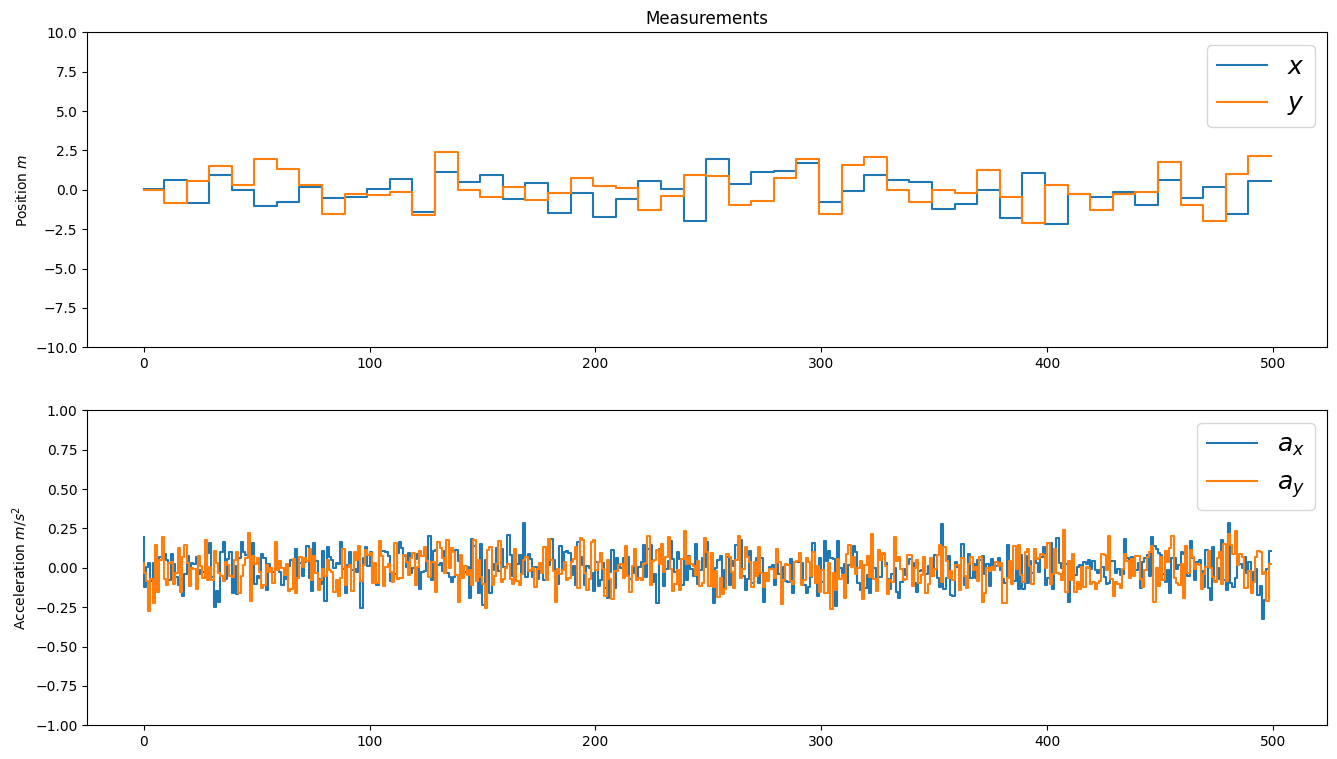

In [11]:
def plot_m():
    fig = plt.figure(figsize=(16,9))
    plt.subplot(211)
    plt.step(range(m),mpx, label='$x$')
    plt.step(range(m),mpy, label='$y$')
    plt.ylabel(r'Position $m$')
    plt.title('Measurements')
    plt.ylim([-10, 10])
    plt.legend(loc='best',prop={'size':18})

    plt.subplot(212)
    plt.step(range(m),max, label='$a_x$')
    plt.step(range(m),may, label='$a_y$')
    plt.ylabel(r'Acceleration $m/s^2$')
    plt.ylim([-1, 1])
    plt.legend(loc='best',prop={'size':18})

    plt.savefig('Kalman-Filter-CA-Measurements.png', dpi=72, transparent=True, bbox_inches='tight')
plot_m()

In [12]:
# Preallocation for Plotting
xt = []
yt = []
dxt= []
dyt= []
ddxt=[]
ddyt=[]
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
Kddy=[]


def savestates(x, Z, P, K):
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    ddxt.append(float(x[4]))
    ddyt.append(float(x[5]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Pddy.append(float(P[5,5]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))
    Kddy.append(float(K[5,0]))

In [13]:
I = np.eye(6)
print(I, I.shape)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]] (6, 6)


In [16]:
for n in range(len(measurements[0])):
 
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = F*x
    
    # Project the error covariance ahead
    P = F*P*F.T + Q
    
    
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = measurements[:,n].reshape(4,1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P
    
    
    
    # Save states (for Plotting)
    savestates(x, Z, P, K)

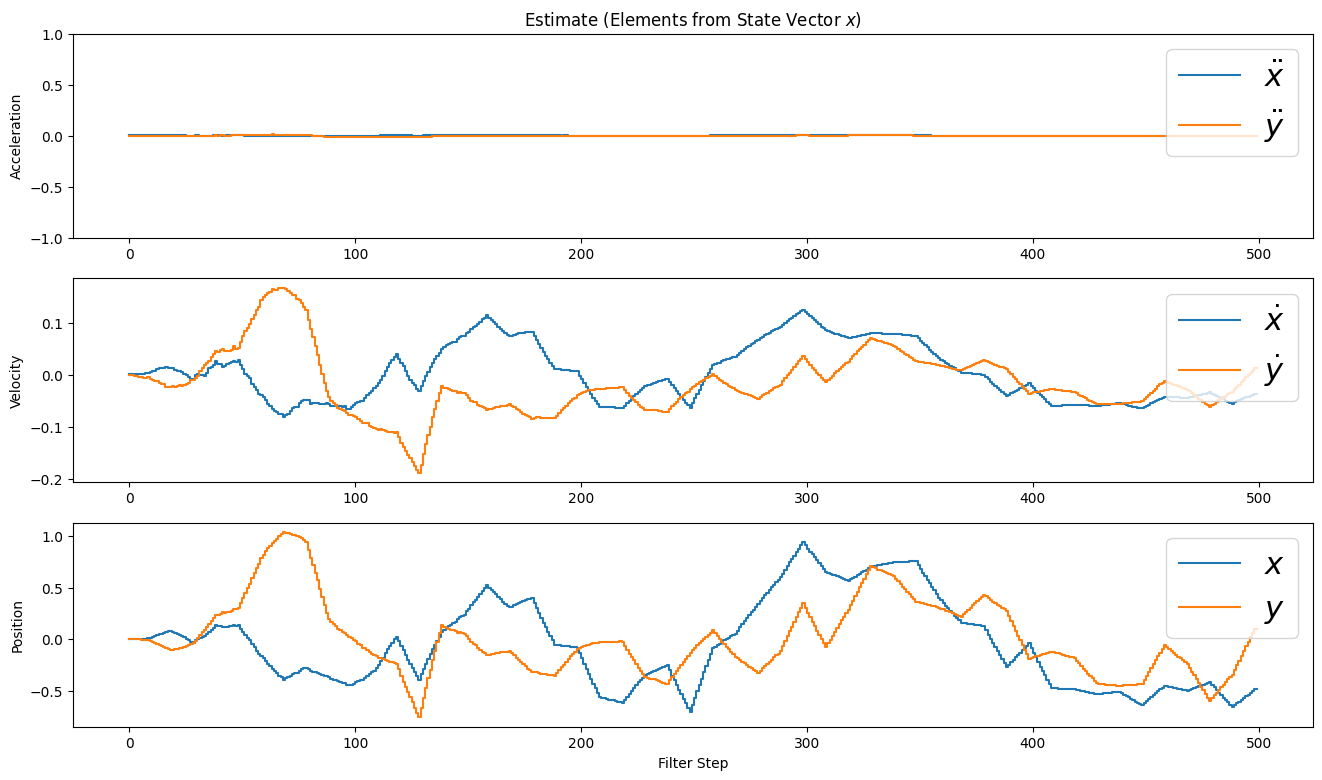

In [17]:
fig = plt.figure(figsize=(16,9))

plt.subplot(311)
plt.step(range(len(measurements[0])),ddxt, label='$\ddot x$')
plt.step(range(len(measurements[0])),ddyt, label='$\ddot y$')

plt.title('Estimate (Elements from State Vector $x$)')
plt.legend(loc='best',prop={'size':22})
plt.ylabel('Acceleration')
plt.ylim([-1,1])

plt.subplot(312)
plt.step(range(len(measurements[0])),dxt, label='$\dot x$')
plt.step(range(len(measurements[0])),dyt, label='$\dot y$')

plt.ylabel('')
plt.legend(loc='best',prop={'size':22})
plt.ylabel('Velocity')
           
plt.subplot(313)
plt.step(range(len(measurements[0])),xt, label='$x$')
plt.step(range(len(measurements[0])),yt, label='$y$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.legend(loc='best',prop={'size':22})
plt.ylabel('Position')
plt.savefig('Kalman-Filter-CA-StateEstimated.png', dpi=72, transparent=True, bbox_inches='tight')

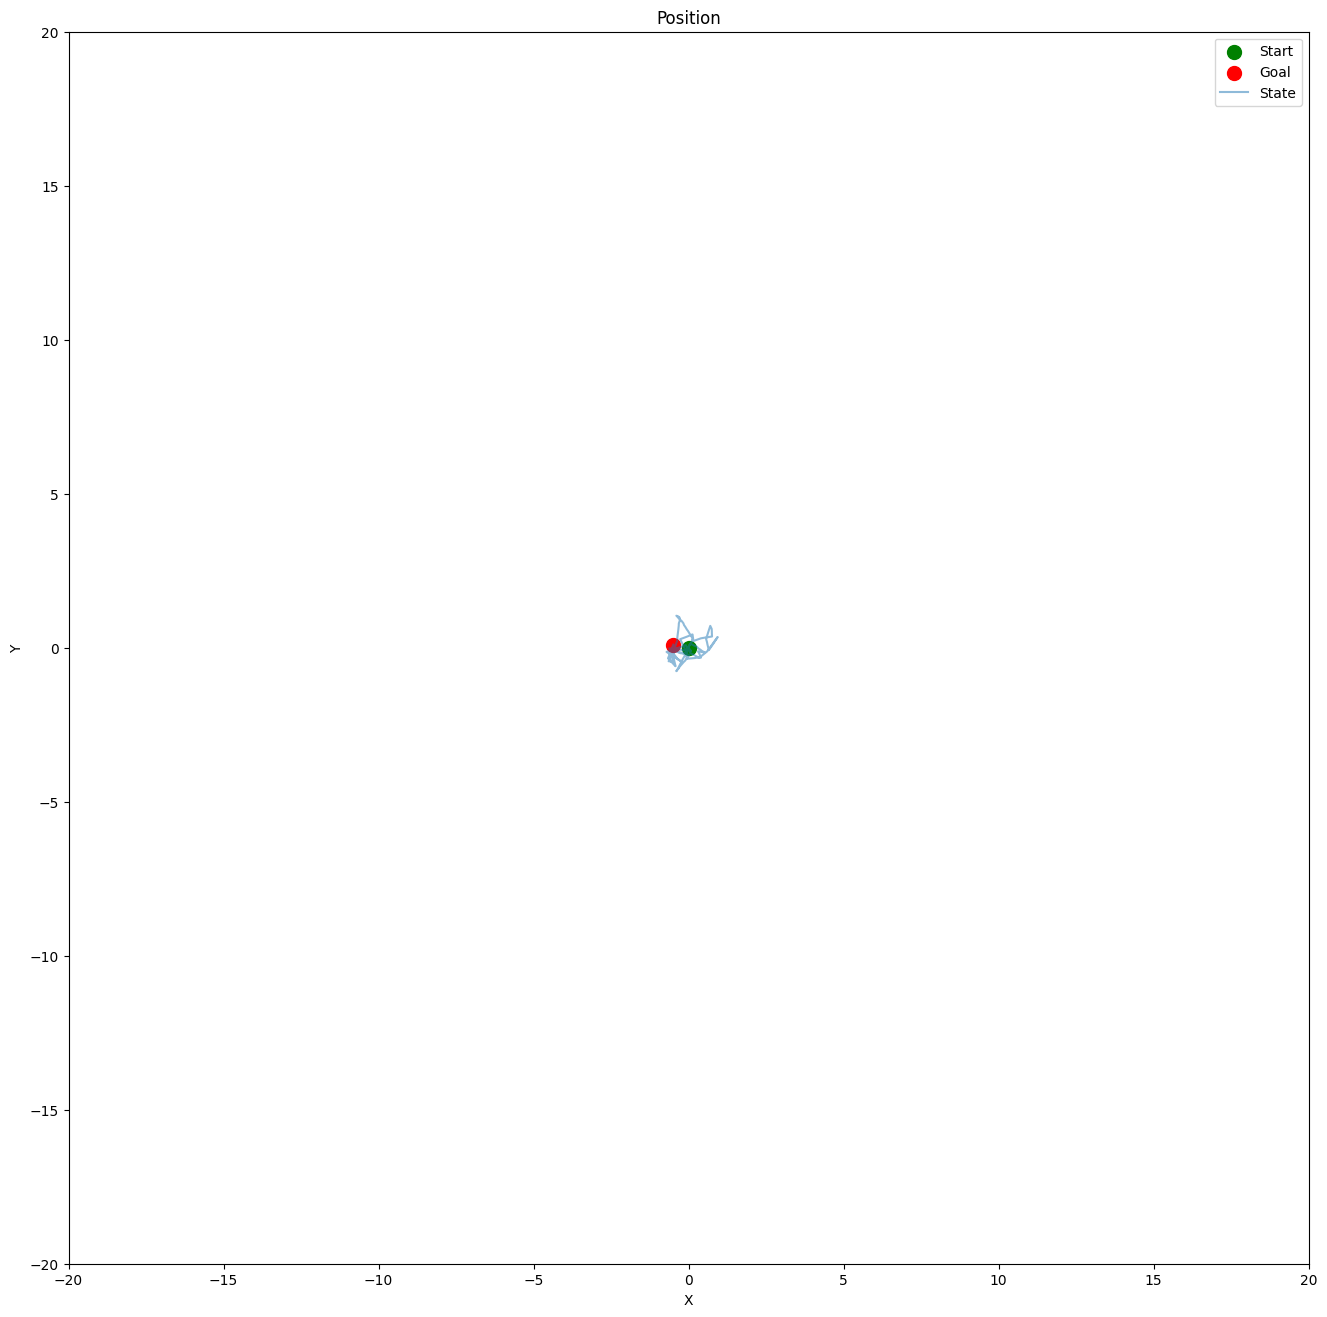

In [18]:
fig = plt.figure(figsize=(16,16))
plt.scatter(xt[0],yt[0], s=100, label='Start', c='g')
plt.scatter(xt[-1],yt[-1], s=100, label='Goal', c='r')
plt.plot(xt,yt, label='State',alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Position')
plt.legend(loc='best')
plt.xlim([-20, 20])
plt.ylim([-20, 20])
plt.savefig('Kalman-Filter-CA-Position.png', dpi=72, transparent=True, bbox_inches='tight')

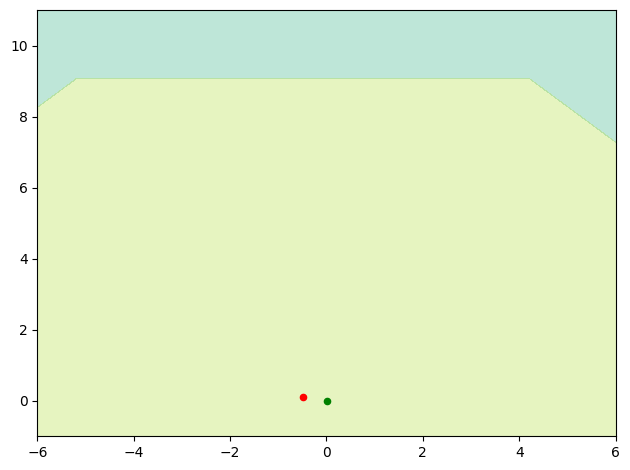

In [19]:
from scipy.stats import multivariate_normal
from matplotlib.animation import FuncAnimation
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
dataSkip = 1

def init_func():
    plt.title('Representing the uncertainty at that time step around the location')
    plt.xlabel('X position in Map')
    plt.ylabel('Y position in Map')

def animate(i):
    ax.clear()

    #plot the gaussian
    x_spread = np.linspace(xt[i] - 3 * np.sqrt(Px[i]), xt[i] + 3 * np.sqrt(Px[i]), 10)
    y_spread = np.linspace(yt[i] - 3 * np.sqrt(Py[i]), yt[i] + 3 * np.sqrt(Py[i]), 10)
    X, Y = np.meshgrid(x_spread, y_spread)
    pos = np.dstack((X, Y))

    rv = multivariate_normal([xt[i], yt[i]], [[Px[i], 0], [0, Py[i]]])
    Z = rv.pdf(pos)
    ax.contourf(X, Y, Z, cmap='viridis', levels=3, alpha=0.3, zorder=0)

    ax.scatter(xt[i], yt[i], s=10, marker='o', c='k', label='waypoints')
    ax.scatter(xt[0], yt[0], s=20, marker='o', c='g', label='start')
    ax.scatter(xt[-1], yt[-1], s=20, marker='o', c='r', label='end')
    ax.set_ylim([-1, 11])
    ax.set_xlim([-6, 6])

ani = FuncAnimation(fig, func=animate, interval=1000, init_func=init_func, frames=np.arange(0, len(xt), dataSkip))
ani.save('animation.html', writer='html')


plt.tight_layout()
plt.show()